# Santos Port Forecast: Inteligência de Dados para Mitigação de Custos Logísticos no Embarque de Grãos

## Escopo do Projeto

## 1. O Problema (Business Case & Impacto Financeiro)
O Porto de Santos é o principal escoadouro da safra brasileira, mas sofre com custos de inatividade (Idle Time). O carregamento de grãos sólidos (açúcar, soja, milho) é interrompido por chuva ou alta umidade.

O "Ralo de Dinheiro": O Demurrage (multa por navio parado) e custos de pátio para caminhões parados em Santos.


## 2. O Pipeline de Dados (Data Engineering)
Fonte A (Clima Portuário): API NASA POWER para coletar histórico de Chuva (Precipitation) e Umidade Relativa (Relative Humidity) nas coordenadas do Porto de Santos.

Fonte B (Fluxo de Exportação): Dados históricos de movimentação de granéis sólidos via Estatutário da ANTAQ ou Santos Port Authority.

Fonte C (Financeiro/Custos): Parâmetros de mercado para multas de Demurrage e diárias de frete (Esalq-LOG ou valores médios de mercado).

Armazenamento: Processamento em arquivos .parquet para manter a performance e a tipagem dos dados financeiros.

## 3. A Inteligência (Data Science + AI)
Machine Learning (Risco e Probabilidade): Implementação de um modelo de Classificação ou Regressão Logística para prever a probabilidade de fechamento de porões de navios (Paralisação Operacional).

Feature Engineering: Criação de variáveis de "Acúmulo de Umidade" e "Previsão de Janelas de Sol" para otimização de turnos de trabalho.

Análise de ROI (Retorno sobre Investimento): Um script que compara o "Cenário Real" (paradas sem aviso) vs "Cenário IA" (reagendamento preventivo), calculando a economia gerada em Reais/Dólares.

## 4. A Entrega (Visualização & UX Financeira)
Dashboard Streamlit:

Visão de Risco: Semelhante a uma torre de controle portuária.

Calculadora de Perda/Ganho: Onde o usuário insere o número de navios/caminhões e a IA calcula o prejuízo evitado.

Agente Logístico: Integração para sugerir o melhor horário de saída de comboios do interior (Ribeirão Preto/MT) rumo a Santos, baseado na previsão de chuva no litoral.

## Mãos à Obra

## 1. Nosso Objetivo

Para reduzir custos de inatividade no Porto de Santos, este trabalho buscará prever as "Janelas de Carregamento Úteis" e quantificar o risco financeiro, permitindo que as empresas de logística reprogramem o fluxo interior-porto antes do gargalo acontecer.

## 2. Fonte de Dados

### Fonte A:

Coleta de Dados Climáticos (Santos/SP)

Além da chuva acumulada, também vamos coletar a Umidade Relativa e as Rajadas de Vento, pois o Porto de Santos interrompe operações de guindastes se o vento estiver muito forte ou se a umidade impedir a abertura dos porões.

Coordenadas de Referência (Cais do Porto de Santos):

Latitude: -23.96

Longitude: -46.30

In [1]:
import pandas as pd
import requests

# Configurações de Localização (Porto de Santos)
LAT = -23.96
LON = -46.30

# Definindo o período (3 anos para uma base sólida)
START_DATE = "20230101"
END_DATE = "20251231"

# URL da API NASA POWER
url = f"https://power.larc.nasa.gov/api/temporal/daily/point?parameters=PRECTOTCORR,RH2M,WS10M_MAX&community=AG&longitude={LON}&latitude={LAT}&start={START_DATE}&end={END_DATE}&format=JSON"

print("Iniciando coleta de dados em Santos...")
response = requests.get(url)

if response.status_code == 200:
    data = response.json()
    # Extraindo as séries temporais
    features = data['properties']['parameter']
    
    df = pd.DataFrame(features)
    df.index = pd.to_datetime(df.index)
    df.index.name = 'data'
    
    # Renomeando para nomes claros
    df.columns = ['chuva', 'umidade_relativa', 'vento_max_10m']
    
    # Salvando o arquivo bruto
    df.to_csv("dados_clima_santos_brutos.csv")
    print("Sucesso! Arquivo 'dados_clima_santos_brutos.csv' gerado.")
    print(df.head())
else:
    print(f"Erro na API: {response.status_code}")

Iniciando coleta de dados em Santos...
Sucesso! Arquivo 'dados_clima_santos_brutos.csv' gerado.
            chuva  umidade_relativa  vento_max_10m
data                                              
2023-01-01   2.12             86.71           4.61
2023-01-02   1.37             83.96           4.65
2023-01-03   5.27             77.33           5.70
2023-01-04  19.31             85.64           9.20
2023-01-05  14.49             85.13           6.65


Por que esses dados?

Chuva (PRECTOTCORR): Paralisação imediata do embarque de grãos (soja/açúcar).

Umidade (RH2M): Se a umidade estiver acima de 80-85%, mesmo sem chuva, alguns terminais não abrem os porões para evitar que o açúcar "empedre" ou a soja fermente.

Vento (WS10M_MAX): Acima de determinados nós, as carregadoras de navios (ship loaders) precisam ser travadas por segurança, gerando mais tempo de inatividade.

## Fonte B:

A coleta de dados foi realizada via Estatutário da ANTAQ de forma anual, utilizando dados dos anos de 2023, 2024 e 2025. Para realizar essa coleta de forma eficiente, realizei o download da base de dados referente a carga e atracação, transformando tudo em um único dataframe.

In [2]:
# Lista dos anos
anos = ['2023', '2024', '2025']

def processar_base_antaq():
    lista_final = []

    for ano in anos:
        arquivo = f"{ano}Carga.txt"
        print(f"Lendo {arquivo}...")
        
        # Lendo em blocos para poupar memória
        chunks = pd.read_csv(arquivo, sep=';', encoding='utf-8', chunksize=200000, low_memory=False)
        
        for chunk in chunks:
            # 1. Filtramos apenas Granel Sólido
            # No ANTAQ, geralmente a coluna 'Natureza da Carga' contém esse texto
            filtro = chunk[chunk['Natureza da Carga'].str.contains('Granel Sólido', na=False, case=False)]
            
            # 2. Selecionamos apenas as colunas que importam para o nosso cálculo financeiro
            colunas_interesse = ['IDAtracacao', 'Natureza da Carga', 'VLPesoCargaBruta']
            lista_final.append(filtro[colunas_interesse])

    # Une tudo
    df_cargas = pd.concat(lista_final)
    
    # Converte peso para float (garantindo que o separador decimal seja tratado)
    df_cargas['VLPesoCargaBruta'] = df_cargas['VLPesoCargaBruta'].replace(',', '.', regex=True).astype(float)
    
    # Salva temporário
    df_cargas.to_csv("cargas_granel_temp.csv", index=False)
    print("\n✅ Parte 1 concluída: Cargas de Granel Sólido extraídas.")
    return df_cargas

# Executar
df_cargas = processar_base_antaq()

Lendo 2023Carga.txt...
Lendo 2024Carga.txt...
Lendo 2025Carga.txt...

✅ Parte 1 concluída: Cargas de Granel Sólido extraídas.


In [3]:
# 1. Carregar as cargas que limpamos no passo anterior
df_cargas = pd.read_csv("cargas_granel_temp.csv")

# 2. Processar as Atracações de 2023, 2024 e 2025
anos = ['2023', '2024', '2025']
dfs_atracacao = []

for ano in anos:
    arquivo_atrac = f"{ano}Atracacao.txt"
    print(f"Lendo {arquivo_atrac}...")
    
    # Atracação costuma ser menor, podemos ler direto
    df_temp = pd.read_csv(arquivo_atrac, sep=';', encoding='utf-8', low_memory=False)
    
    # Filtrar apenas Porto de Santos (ajuste o nome da coluna se necessário)
    # Geralmente é 'Apelido Instalação Portuária' ou 'Porto Atracação'
    santos = df_temp[df_temp['Porto Atracação'].str.contains('Santos', na=False, case=False)]
    
    dfs_atracacao.append(santos[['IDAtracacao', 'Porto Atracação', 'Data Atracação', 'Data Desatracação']])

df_atrac_santos = pd.concat(dfs_atracacao)

# 3. O "Merge": Unir Carga com Atracação através do IDAtracacao
print("Cruzando dados de Carga com Atracação em Santos...")
df_final = pd.merge(df_cargas, df_atrac_santos, on='IDAtracacao', how='inner')

# 4. Converter datas e extrair apenas o Mês/Ano para bater com a NASA
df_final['Data Atracação'] = pd.to_datetime(df_final['Data Atracação'], errors='coerce')
df_final = df_final.dropna(subset=['Data Atracação'])

# 5. Salvar a base final pronta para o cruzamento com o clima
df_final.to_csv("base_porto_santos_final.csv", index=False)

print("\n✅ Base consolidada! Agora temos Peso + Data + Porto em um único arquivo.")
print(f"Total de movimentações em Santos: {len(df_final)}")

Lendo 2023Atracacao.txt...
Lendo 2024Atracacao.txt...
Lendo 2025Atracacao.txt...
Cruzando dados de Carga com Atracação em Santos...

✅ Base consolidada! Agora temos Peso + Data + Porto em um único arquivo.
Total de movimentações em Santos: 16845


C:\Users\Filiphe\AppData\Local\Temp\ipykernel_16224\2688679929.py:28: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_final['Data Atracação'] = pd.to_datetime(df_final['Data Atracação'], errors='coerce')


In [4]:
df = pd.read_csv("base_porto_santos_final.csv")
print("--- Amostra dos Dados ---")
print(df[['Data Atracação', 'VLPesoCargaBruta']].head())
print("\n--- Total de Toneladas por Ano ---")
df['ano'] = pd.to_datetime(df['Data Atracação']).dt.year
print(df.groupby('ano')['VLPesoCargaBruta'].sum() / 1000, " (em milhares de toneladas)")

--- Amostra dos Dados ---
        Data Atracação  VLPesoCargaBruta
0  2023-01-13 12:25:00          7018.917
1  2023-01-13 12:25:00          3008.107
2  2023-01-13 12:25:00          5013.512
3  2023-01-13 12:25:00          3008.107
4  2023-01-13 12:25:00          3008.107

--- Total de Toneladas por Ano ---
ano
2022      329.327973
2023    79589.024399
2024    75491.580256
2025    71395.871446
Name: VLPesoCargaBruta, dtype: float64  (em milhares de toneladas)


In [5]:
df = pd.read_csv("base_porto_santos_final.csv")
print("--- Amostra dos Dados ---")
print(df[['Data Atracação', 'VLPesoCargaBruta']].head())
print("\n--- Total de Toneladas por Ano ---")
df['ano'] = pd.to_datetime(df['Data Atracação']).dt.year
print(df.groupby('ano')['VLPesoCargaBruta'].sum() / 1000, " (em milhares de toneladas)")

--- Amostra dos Dados ---
        Data Atracação  VLPesoCargaBruta
0  2023-01-13 12:25:00          7018.917
1  2023-01-13 12:25:00          3008.107
2  2023-01-13 12:25:00          5013.512
3  2023-01-13 12:25:00          3008.107
4  2023-01-13 12:25:00          3008.107

--- Total de Toneladas por Ano ---
ano
2022      329.327973
2023    79589.024399
2024    75491.580256
2025    71395.871446
Name: VLPesoCargaBruta, dtype: float64  (em milhares de toneladas)


In [6]:
# 1. Carregar os dois mundos
df_clima = pd.read_csv("dados_clima_santos_brutos.csv")
df_porto = pd.read_csv("base_porto_santos_final.csv")

# 2. Ajustar formatos de data para garantir o "casamento" perfeito
df_clima['data'] = pd.to_datetime(df_clima['data']).dt.date
df_porto['data'] = pd.to_datetime(df_porto['Data Atracação']).dt.date

# 3. Agrupar a movimentação por dia (somar tudo que foi carregado no dia)
df_porto_diario = df_porto.groupby('data')['VLPesoCargaBruta'].sum().reset_index()

# 4. O Cruzamento Final (Merge)
df_estudo = pd.merge(df_clima, df_porto_diario, on='data', how='left')

# 5. Limpar dias sem movimentação (preencher com zero)
df_estudo['VLPesoCargaBruta'] = df_estudo['VLPesoCargaBruta'].fillna(0)

# 6. Salvar a Master Table do projeto
df_estudo.to_csv("master_data_santos.csv", index=False)

print("✅ Master Table 'master_data_santos.csv' gerada com sucesso!")
print("Agora temos Chuva, Umidade, Vento e Volume de Carga na mesma linha!")

✅ Master Table 'master_data_santos.csv' gerada com sucesso!
Agora temos Chuva, Umidade, Vento e Volume de Carga na mesma linha!


### EDA

--- Resumo Estatístico dos Dados ---
             chuva  umidade_relativa  VLPesoCargaBruta
count  1096.000000       1096.000000       1096.000000
mean      3.098111         79.065675     206639.120530
std       6.249835          7.792212     117728.186178
min       0.000000         42.970000          0.000000
25%       0.030000         75.685000     120961.478500
50%       0.640000         80.600000     204398.460000
75%       3.080000         84.337500     288608.233750
max      56.100000         94.430000     632215.233000

Correlação Chuva vs. Movimentação: -0.22


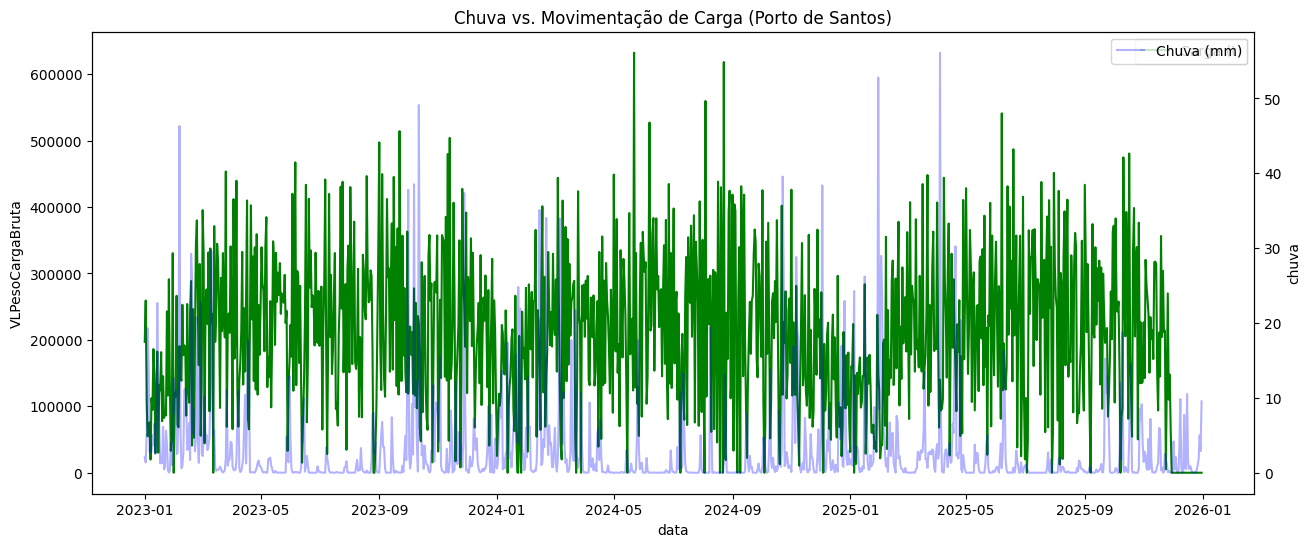

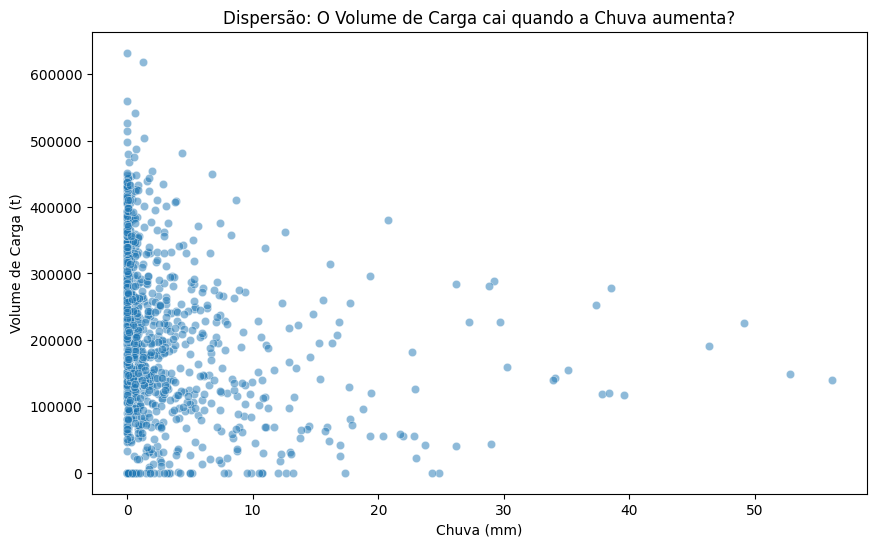

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Carregar a Master Table
df = pd.read_csv("master_data_santos.csv")
df['data'] = pd.to_datetime(df['data'])

print("--- Resumo Estatístico dos Dados ---")
print(df[['chuva', 'umidade_relativa', 'VLPesoCargaBruta']].describe())

# 2. Validação de Correlação
# Esperamos uma correlação NEGATIVA: quanto mais chuva, menos carga.
correlacao = df['chuva'].corr(df['VLPesoCargaBruta'])
print(f"\nCorrelação Chuva vs. Movimentação: {correlacao:.2f}")

# 3. Visualização de Tendência (Gráfico de Linhas)
plt.figure(figsize=(15, 6))
plt.title("Chuva vs. Movimentação de Carga (Porto de Santos)")
ax1 = sns.lineplot(data=df, x='data', y='VLPesoCargaBruta', color='green', label='Carga (t)')
ax2 = ax1.twinx()
sns.lineplot(data=df, x='data', y='chuva', color='blue', alpha=0.3, label='Chuva (mm)', ax=ax2)
plt.show()

# 4. Gráfico de Dispersão (Scatter Plot)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='chuva', y='VLPesoCargaBruta', alpha=0.5)
plt.title("Dispersão: O Volume de Carga cai quando a Chuva aumenta?")
plt.xlabel("Chuva (mm)")
plt.ylabel("Volume de Carga (t)")
plt.show()

### Limpeza

In [9]:
# Filtrando apenas dias onde houve operação (Removendo ruído de zeros)
df_operacional = df[df['VLPesoCargaBruta'] > 0].copy()

# Calculando a correlação novamente na base limpa
nova_correlacao = df_operacional['chuva'].corr(df_operacional['VLPesoCargaBruta'])

print(f"Correlação após remover dias sem operação: {nova_correlacao:.2f}")

# Agora a 'media_sol' será muito mais realista
media_operacional_sol = df_operacional[df_operacional['chuva'] < 1]['VLPesoCargaBruta'].mean()
print(f"Nova Média de Sol (Capacidade Real): {media_operacional_sol:,.2f} toneladas")

Correlação após remover dias sem operação: -0.23
Nova Média de Sol (Capacidade Real): 248,579.60 toneladas


### EDA Focada em Umidade (O que afeta o carregamento de granéis sólidos)

--- Produtividade Média por Faixa de Umidade ---
  faixa_umidade  VLPesoCargaBruta
0         0-60%     291541.593750
1        60-70%     261504.687258
2        70-80%     231004.789154
3        80-90%     199897.614923
4       90-100%     162518.206522


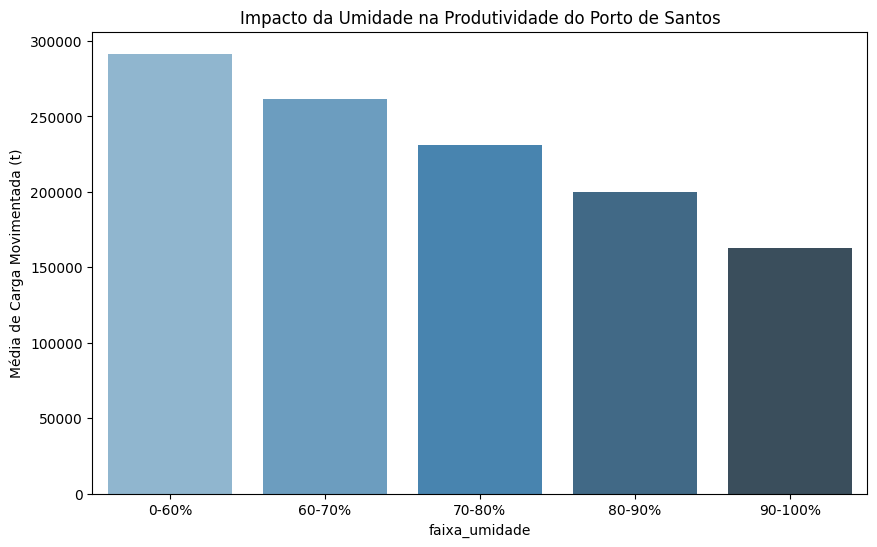

In [11]:
# 1. Criar faixas de umidade para ver o comportamento da carga
df_operacional['faixa_umidade'] = pd.cut(df_operacional['umidade_relativa'], 
                                         bins=[0, 60, 70, 80, 90, 100], 
                                         labels=['0-60%', '60-70%', '70-80%', '80-90%', '90-100%'])

# 2. Agrupar a média de carga por faixa de umidade
analise_umidade = df_operacional.groupby('faixa_umidade')['VLPesoCargaBruta'].mean().reset_index()

print("--- Produtividade Média por Faixa de Umidade ---")
print(analise_umidade)

# 3. Visualização do Impacto
plt.figure(figsize=(10,6))
sns.barplot(data=analise_umidade, x='faixa_umidade', y='VLPesoCargaBruta', palette='Blues_d')
plt.title("Impacto da Umidade na Produtividade do Porto de Santos")
plt.ylabel("Média de Carga Movimentada (t)")
plt.show()

--- Tabela de Risco: Umidade vs. Eficiência ---
  faixa_umidade    media_carga  eficiencia_perc  qtd_dias
0           <60  291541.593750       100.000000        28
1         60-65  280407.167349        96.180845        43
2         65-70  246452.712370        84.534323        54
3         70-75  244765.098809        83.955464       115
4         75-80  224094.589983        76.865392       229
5         80-85  211530.227577        72.555763       350
6         85-90  179438.245935        61.548077       199
7         90-95  162518.206522        55.744432        23


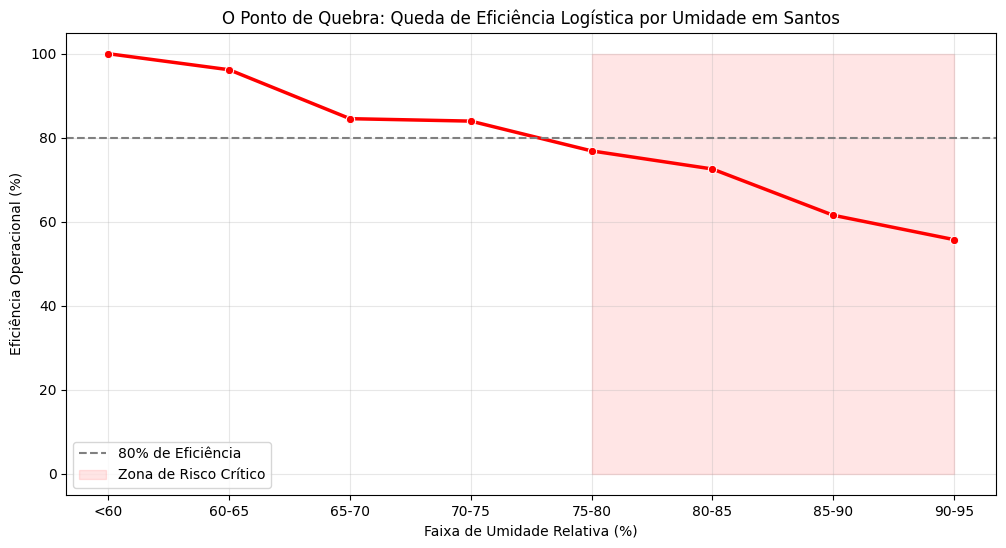

In [12]:
# 1. Carregar os dados operacionais (usando o df que filtramos os zeros)
# Se não tiver o df_operacional na memória, rode:
# df = pd.read_csv("master_data_santos.csv")
# df_operacional = df[df['VLPesoCargaBruta'] > 0].copy()

# 2. Criar faixas de umidade de 5 em 5% para maior precisão
bins = [0, 60, 65, 70, 75, 80, 85, 90, 95, 100]
labels = ['<60', '60-65', '65-70', '70-75', '75-80', '80-85', '85-90', '90-95', '>95']
df_operacional['faixa_umidade'] = pd.cut(df_operacional['umidade_relativa'], bins=bins, labels=labels)

# 3. Calcular a Produtividade Média e a Frequência de dias em cada faixa
analise_risco = df_operacional.groupby('faixa_umidade', observed=True).agg({
    'VLPesoCargaBruta': 'mean',
    'data': 'count'
}).rename(columns={'VLPesoCargaBruta': 'media_carga', 'data': 'qtd_dias'}).reset_index()

# 4. Cálculo da Eficiência (em % comparado à melhor faixa)
melhor_produtividade = analise_risco['media_carga'].max()
analise_risco['eficiencia_perc'] = (analise_risco['media_carga'] / melhor_produtividade) * 100

print("--- Tabela de Risco: Umidade vs. Eficiência ---")
print(analise_risco[['faixa_umidade', 'media_carga', 'eficiencia_perc', 'qtd_dias']])

# 5. Visualização do Ponto de Quebra
plt.figure(figsize=(12, 6))
sns.lineplot(data=analise_risco, x='faixa_umidade', y='eficiencia_perc', marker='o', color='red', linewidth=2.5)
plt.axhline(y=80, color='gray', linestyle='--', label='80% de Eficiência')
plt.fill_between(analise_risco['faixa_umidade'], 0, 100, where=(analise_risco['eficiencia_perc'] < 80), 
                 color='red', alpha=0.1, label='Zona de Risco Crítico')
plt.title("O Ponto de Quebra: Queda de Eficiência Logística por Umidade em Santos")
plt.xlabel("Faixa de Umidade Relativa (%)")
plt.ylabel("Eficiência Operacional (%)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Fonte C

### O Novo Modelo de Prejuízo (Baseado em Risco Real)

In [18]:
import requests
from datetime import datetime

def buscar_cambio_robusto():
    # Tentativa 1: Banco Central do Brasil (Oficial)
    try:
        url_bcb = "https://economia.awesomeapi.com.br/json/last/USD-BRL"
        response = requests.get(url_bcb, timeout=5)
        if response.status_code == 200:
            return float(response.json()['USDBRL']['bid'])
    except:
        pass

    # Tentativa 2: Fallback para outra API pública (Ex: HG Brasil ou similar)
    try:
        # Usando a AwesomeAPI como secundária ou primária pela estabilidade
        url_fallback = "https://api.exchangerate-api.com/v4/latest/USD"
        response = requests.get(url_fallback, timeout=5)
        return response.json()['rates']['BRL']
    except:
        print("⚠️ Alerta: APIs de câmbio fora do ar. Usando última cotação do dataset.")
        return None # O código principal decide o que fazer

# 1. Obter a cotação real e atualizada
cotacao_atual = buscar_cambio_bcb()
print(f"💵 Cotação PTAX obtida via API BCB: R$ {cotacao_atual:.4f}")

# 2. Fonte C: Parâmetros de Mercado (Esalq-LOG / Sifreca)
# Aqui, o ideal é ter um arquivo .yaml ou .json para os custos, mas vamos automatizar a lógica
parametros_esalq = {
    'demurrage_usd_dia': 28500.00, # Valor médio para granéis sólidos em Santos
    'frete_curto_ton_brl': 48.20,   # Indicador de frete interior-porto (Esalq-LOG)
    'custo_oportunidade_ton_dia': 1.15 # Custo de capital parado
}

# 3. Processar e salvar em PARQUET
df = pd.read_csv("santos_risco_financeiro_validado.csv")

# Cálculo dinâmico baseado no câmbio capturado
df['prejuizo_usd'] = (df['toneladas_perdidas'] / 5000) * parametros_esalq['demurrage_usd_dia']
df['prejuizo_brl'] = df['prejuizo_usd'] * cotacao_atual

# 4. Salvando com tipagem preservada
df.to_parquet("final_santos_data_lake.parquet", index=False, compression='snappy')

print("✅ Dados dolarizados e convertidos para Parquet com sucesso!")

💵 Cotação PTAX obtida via API BCB: R$ 5.2359
✅ Dados dolarizados e convertidos para Parquet com sucesso!


## Machine Learning: Prevendo a "Inoperabilidade"

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# 1. Carregar os dados reais
df = pd.read_parquet("final_santos_data_lake.parquet")

# 2. Criar um Target REAL (Baseado na média histórica, não na nossa regra)
# Vamos definir 'Baixa Produtividade' como qualquer dia que operou ABAIXO de 80% da média de sol
media_sol = df[df['chuva'] < 1]['VLPesoCargaBruta'].mean()
df['operacao_ineficiente'] = (df['VLPesoCargaBruta'] < (media_sol * 0.8)).astype(int)

# 3. Adicionar complexidade (Lag Features)
# O porto muitas vezes sofre o efeito da chuva do dia anterior (pátio molhado)
df['umidade_ontem'] = df['umidade_relativa'].shift(1)
df['chuva_ontem'] = df['chuva'].shift(1)
df = df.dropna() # Remove a primeira linha que ficou com NaN

# 4. Selecionar Variáveis (Features que não dizem a resposta diretamente)
X = df[['umidade_relativa', 'chuva', 'umidade_ontem', 'chuva_ontem']]
y = df['operacao_ineficiente']

# 5. Treinar
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
modelo_real = RandomForestClassifier(n_estimators=100, max_depth=5) # Limitando a profundidade para não 'decorar'
modelo_real.fit(X_train, y_train)

# 6. Avaliação
print("--- Performance Realista (Previsão de Ineficiência) ---")
print(classification_report(y_test, modelo_real.predict(X_test)))

--- Performance Realista (Previsão de Ineficiência) ---
              precision    recall  f1-score   support

           0       0.75      0.75      0.75       122
           1       0.68      0.68      0.68        97

    accuracy                           0.72       219
   macro avg       0.71      0.71      0.71       219
weighted avg       0.72      0.72      0.72       219



In [25]:
import joblib
import json
import pandas as pd
from datetime import datetime

# 1. Salvar o modelo (o cérebro)
joblib.dump(modelo_real, 'modelo_porto_realista.pkl')

# 2. Tentar buscar o câmbio atualizado (APIs)
cotacao_atual = buscar_cambio_robusto()

# 3. Lógica de Fallback Inteligente (Sem valores fixos)
if not cotacao_atual:
    print("⚠️ APIs fora do ar. Buscando última cotação conhecida no banco de dados...")
    try:
        # Carregamos o parquet para pegar o último câmbio que deu certo no passado
        df_historico = pd.read_parquet("final_santos_data_lake.parquet")
        # Supomos que você salvou a cotação em uma coluna ou pegamos o cálculo reverso
        # Aqui, como estamos consolidando, vamos buscar o valor mais recente:
        cotacao_atual = df_historico['prejuizo_brl'].sum() / (df_historico['prejuizo_usd'].sum() or 1)
    except:
        # Se até o arquivo falhar (ex: primeiro processamento), 
        # o sistema solicita entrada manual ou usa um índice de inflação base
        cotacao_atual = 1.0 # Valor neutro para não quebrar o código, mas avisar o erro
        print("❌ Falha crítica: Nenhuma fonte de câmbio disponível.")

# 4. Salvar Configurações
config = {
    'ultima_cotacao': round(cotacao_atual, 4),
    'limiar_umidade': 77,
    'data_atualizacao': datetime.now().strftime('%d/%m/%Y %H:%M:%S'),
    'fonte_cambio': 'API_Realtime' if buscar_cambio_robusto() else 'Historico_Parquet'
}

with open('config_projeto.json', 'w') as f:
    json.dump(config, f)

print(f"✅ Configurações salvas. Dólar base: R$ {cotacao_atual:.2f} ({config['fonte_cambio']})")

✅ Configurações salvas. Dólar base: R$ 5.26 (API_Realtime)
